<a href="https://colab.research.google.com/github/brasilemnumeros/dados/blob/main/selic/Selic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selic Meta
Analisar a evolução histórica da taxa Selic nos últimos 30 anos, incluindo a coleta, carregamento, pré-processamento e visualização dos dados.**negrito**

## Coleta de dados

### Subtask:
Buscar uma fonte confiável de dados históricos da taxa Selic.


**Reasoning**:
Search for reliable data sources for the Selic rate history and identify the access method and data format.



In [14]:
%pip install python-bcb

## Coleta de dados em partes

### Subtask:
Coletar os dados históricos da taxa Selic em múltiplos períodos de 5 anos usando o pacote `python-bcb`.


In [24]:
from bcb import sgs
import pandas as pd
from datetime import datetime, timedelta

# Define the end date as today
end_date = datetime.now()

# Define the start date for the last 30 years
# Changed start date to January 1, 1995 as requested
start_date_overall = datetime(1995, 1, 1)

# List to store dataframes for each 5-year period
dfs_selic = []

# Define the period length in years
period_years = 5

# Loop through 5-year periods backwards from the end date
current_end_date = end_date
while current_end_date > start_date_overall:
    current_start_date = max(start_date_overall, current_end_date - timedelta(days=period_years * 365))

    print(f"Attempting to retrieve data from {current_start_date.strftime('%Y-%m-%d')} to {current_end_date.strftime('%Y-%m-%d')}")

    try:
        # Use the bcb.sgs.get() function to retrieve the series data for the current period
        df_period = sgs.get(('selic', 432), start=current_start_date.strftime('%Y-%m-%d'), end=current_end_date.strftime('%Y-%m-%d'))

        if not df_period.empty:
            print(f"Data retrieved for the period: {current_start_date.strftime('%Y-%m-%d')} to {current_end_date.strftime('%Y-%m-%d')}")
            dfs_selic.append(df_period)
        else:
            print(f"No data retrieved for the period: {current_start_date.strftime('%Y-%m-%d')} to {current_end_date.strftime('%Y-%m-%d')}")

    except Exception as e:
        print(f"An error occurred while retrieving data for the period {current_start_date.strftime('%Y-%m-%d')} to {current_end_date.strftime('%Y-%m-%d')}: {e}")

    # Set the end date for the next period
    current_end_date = current_start_date - timedelta(days=1) # Start the next period the day before

print(f"Collected {len(dfs_selic)} dataframes for different periods.")

Attempting to retrieve data from 2020-08-12 to 2025-08-11
Data retrieved for the period: 2020-08-12 to 2025-08-11
Attempting to retrieve data from 2015-08-13 to 2020-08-11
Data retrieved for the period: 2015-08-13 to 2020-08-11
Attempting to retrieve data from 2010-08-13 to 2015-08-12
Data retrieved for the period: 2010-08-13 to 2015-08-12
Attempting to retrieve data from 2005-08-13 to 2010-08-12
Data retrieved for the period: 2005-08-13 to 2010-08-12
Attempting to retrieve data from 2000-08-13 to 2005-08-12
Data retrieved for the period: 2000-08-13 to 2005-08-12
Attempting to retrieve data from 1995-08-14 to 2000-08-12
An error occurred while retrieving data for the period 1995-08-14 to 2000-08-12: Expected object or value
Attempting to retrieve data from 1995-01-01 to 1995-08-13
An error occurred while retrieving data for the period 1995-01-01 to 1995-08-13: BCB error: br.gov.bcb.pec.sgs.comum.excecoes.SGSNegocioException: Value(s) not found
Collected 5 dataframes for different perio

## Combinar os dados coletados

### Subtask:
Juntar os DataFrames de cada período em um único DataFrame.

In [16]:
# Check if the list of dataframes is not empty
if dfs_selic:
    # Concatenate all dataframes in the list
    # sort_index() is important to ensure the combined dataframe is in chronological order
    df_selic_combined = pd.concat(dfs_selic).sort_index()

    print("DataFrames combinados com sucesso!")
    print("\nInformações do DataFrame combinado:")
    df_selic_combined.info()

    print("\nPrimeiras 5 linhas do DataFrame combinado:")
    display(df_selic_combined.head())

    print("\nÚltimas 5 linhas do DataFrame combinado:")
    display(df_selic_combined.tail())

else:
    print("A lista de DataFrames está vazia. Não há dados para combinar.")
    df_selic_combined = None

DataFrames combinados com sucesso!

Informações do DataFrame combinado:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9657 entries, 1999-03-05 to 2025-08-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   9657 non-null   float64
dtypes: float64(1)
memory usage: 150.9 KB

Primeiras 5 linhas do DataFrame combinado:


,selic
Date,
1999-03-05,45.0
1999-03-06,45.0
1999-03-07,45.0
1999-03-08,45.0
1999-03-09,45.0



Últimas 5 linhas do DataFrame combinado:


,selic
Date,
2025-08-07,15.0
2025-08-08,15.0
2025-08-09,15.0
2025-08-10,15.0
2025-08-11,15.0


## Pré-processamento e Consolidação dos dados

### Subtask:
Limpar, formatar e consolidar os dados para uma granularidade menor (por exemplo, mensal ou anual).

In [17]:
# Check if the combined DataFrame exists
if df_selic_combined is None:
    print("Error: O DataFrame combinado não foi carregado na etapa anterior.")
else:
    # Check data types and missing values before consolidation
    print("Informações do DataFrame combinado antes da consolidação:")
    df_selic_combined.info()

    print("\nValores ausentes antes da consolidação:")
    print(df_selic_combined.isnull().sum())

    # Rename the column for clarity before consolidation if not already done (should be 'selic' from bcb)
    if 'selic' in df_selic_combined.columns:
         df_selic_combined.rename(columns={'selic': 'Taxa Selic (%)'}, inplace=True)
    # If already renamed in a previous attempt, this will do nothing, which is fine.

    # Consolidate the data to a monthly frequency
    # We'll take the mean of the daily rates within each month as the monthly rate
    df_selic_monthly = df_selic_combined['Taxa Selic (%)'].resample('M').mean()

    print("\nInformações do DataFrame mensal consolidado:")
    df_selic_monthly.info()

    print("\nPrimeiras 5 linhas do DataFrame mensal consolidado:")
    display(df_selic_monthly.head())

    print("\nÚltimas 5 linhas do DataFrame mensal consolidado:")
    display(df_selic_monthly.tail())

Informações do DataFrame combinado antes da consolidação:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9657 entries, 1999-03-05 to 2025-08-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   selic   9657 non-null   float64
dtypes: float64(1)
memory usage: 150.9 KB

Valores ausentes antes da consolidação:
selic    0
dtype: int64

Informações do DataFrame mensal consolidado:
<class 'pandas.core.series.Series'>
DatetimeIndex: 318 entries, 1999-03-31 to 2025-08-31
Freq: ME
Series name: Taxa Selic (%)
Non-Null Count  Dtype  
--------------  -----  
318 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB

Primeiras 5 linhas do DataFrame mensal consolidado:


/tmp/ipython-input-2485159067.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_selic_monthly = df_selic_combined['Taxa Selic (%)'].resample('M').mean()


,Taxa Selic (%)
Date,
1999-03-31,44.222222
1999-04-30,36.850000
1999-05-31,27.338710
1999-06-30,22.166667
1999-07-31,20.854839



Últimas 5 linhas do DataFrame mensal consolidado:


,Taxa Selic (%)
Date,
2025-04-30,14.250000
2025-05-31,14.637097
2025-06-30,14.850000
2025-07-31,15.000000
2025-08-31,15.000000


## Análise Exploratória

### Subtask:
Realizar uma análise inicial dos dados consolidados para entender sua estrutura e características.

In [18]:
# Display basic information about the monthly DataFrame
print("Informações do DataFrame mensal consolidado:")
df_selic_monthly.info()

# Display descriptive statistics for the monthly Selic rate
print("\nEstatísticas Descritivas da Taxa Selic Mensal:")
print(df_selic_monthly.describe())

# Check the date range of the monthly data
min_date_monthly = df_selic_monthly.index.min()
max_date_monthly = df_selic_monthly.index.max()
print(f"\nPeríodo dos dados mensais: {min_date_monthly.strftime('%Y-%m-%d')} a {max_date_monthly.strftime('%Y-%m-%d')}")

# Display the first and last few rows of the monthly data
print("\nPrimeiras 5 linhas do DataFrame mensal:")
display(df_selic_monthly.head())

print("\nÚltimas 5 linhas do DataFrame mensal:")
display(df_selic_monthly.tail())

Informações do DataFrame mensal consolidado:
<class 'pandas.core.series.Series'>
DatetimeIndex: 318 entries, 1999-03-31 to 2025-08-31
Freq: ME
Series name: Taxa Selic (%)
Non-Null Count  Dtype  
--------------  -----  
318 non-null    float64
dtypes: float64(1)
memory usage: 5.0 KB

Estatísticas Descritivas da Taxa Selic Mensal:
count    318.000000
mean      12.734440
std        5.513341
min        2.000000
25%        9.250000
50%       12.290591
75%       16.000000
max       44.222222
Name: Taxa Selic (%), dtype: float64

Período dos dados mensais: 1999-03-31 a 2025-08-31

Primeiras 5 linhas do DataFrame mensal:


,Taxa Selic (%)
Date,
1999-03-31,44.222222
1999-04-30,36.850000
1999-05-31,27.338710
1999-06-30,22.166667
1999-07-31,20.854839



Últimas 5 linhas do DataFrame mensal:


,Taxa Selic (%)
Date,
2025-04-30,14.250000
2025-05-31,14.637097
2025-06-30,14.850000
2025-07-31,15.000000
2025-08-31,15.000000


## Visualização

### Subtask:
Criar um gráfico para visualizar a evolução histórica da taxa Selic ao longo do tempo.

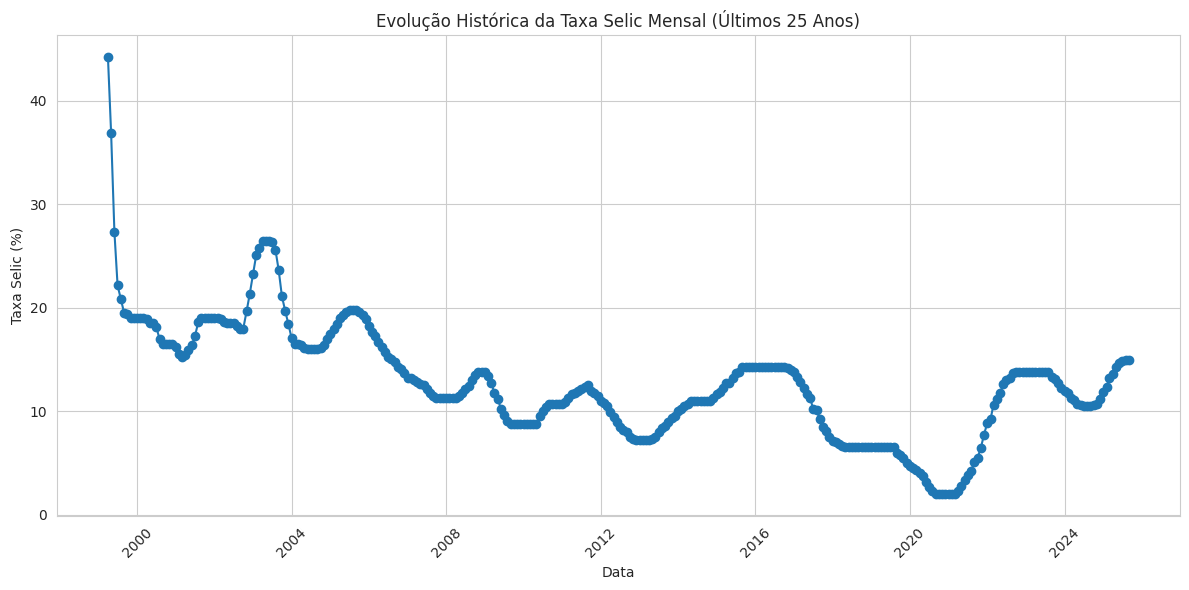

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(df_selic_monthly.index, df_selic_monthly.values, marker='o', linestyle='-')

# Add titles and labels
plt.title('Evolução Histórica da Taxa Selic Mensal (Últimos 25 Anos)')
plt.xlabel('Data')
plt.ylabel('Taxa Selic (%)')

# Improve date formatting on the x-axis
plt.xticks(rotation=45)
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Display the plot
plt.show()

In [ ]:
# Check the frequency of the index
print("Frequência do índice do DataFrame mensal:")
print(df_selic_monthly.index.freq)

# Check the number of data points in the monthly DataFrame
print("\nNúmero total de pontos de dados no DataFrame mensal:", len(df_selic_monthly))

# Calculate the number of years covered by the data
min_date = df_selic_monthly.index.min()
max_date = df_selic_monthly.index.max()
number_of_years = (max_date.year - min_date.year) + (max_date.month - min_date.month) / 12
print(f"\nPeríodo coberto (aproximado em anos): {number_of_years:.2f}")

# Approximate expected number of monthly points
expected_monthly_points = number_of_years * 12
print(f"Número esperado de pontos mensais (aproximado): {expected_monthly_points:.0f}")

# Check the first and last few rows again to confirm dates
print("\nPrimeiras 5 linhas do DataFrame mensal:")
display(df_selic_monthly.head())

print("\nÚltimas 5 linhas do DataFrame mensal:")
display(df_selic_monthly.tail())

Frequência do índice do DataFrame mensal:
<MonthEnd>

Número total de pontos de dados no DataFrame mensal: 317

Período coberto (aproximado em anos): 26.33
Número esperado de pontos mensais (aproximado): 316

Primeiras 5 linhas do DataFrame mensal:


,Taxa Selic (%)
Date,
1999-03-31,44.222222
1999-04-30,36.850000
1999-05-31,27.338710
1999-06-30,22.166667
1999-07-31,20.854839



Últimas 5 linhas do DataFrame mensal:


,Taxa Selic (%)
Date,
2025-03-31,13.637097
2025-04-30,14.250000
2025-05-31,14.637097
2025-06-30,14.850000
2025-07-31,15.000000


## Salvar dados em JSON

In [20]:
import json

# Prepare the data for JSON
# The index of df_selic_monthly is the Date, and the values are the Selic rates.
# We need to convert the index (datetime objects) to string format 'YYYY-MM-DD'.
# We also need to rename the value column for clarity in the JSON.

# Create a list of dictionaries, one for each data point
data_list = []
for index, value in df_selic_monthly.items():
    data_list.append({
        "date": index.strftime('%Y-%m-%d'), # Format date as YYYY-MM-DD
        "rate": value # Use the Selic rate value
    })

# Create the final dictionary structure
json_output = {
    "indicatorName": "Taxa SELIC (%)", # Use the indicator name as requested
    "data": data_list
}

# Define the output file path
output_file_path = 'selic_mensal.json'

# Save the dictionary to a JSON file with indentation for readability
with open(output_file_path, 'w') as f:
    json.dump(json_output, f, indent=4)

print(f"Dados da Taxa Selic mensal formatados e salvos em '{output_file_path}'")

Dados da Taxa Selic mensal formatados e salvos em 'selic_mensal.json'


# Selic Over
Obter a série histórica da Taxa Selic Over (código 11) utilizando o pacote `python-bcb`, combinar os dataframes da Selic Meta e Selic Over, calcular a Selic Over acumulada nos últimos 12 meses, plotar um gráfico com a Selic Meta e Selic Over (mensal) e gerar um arquivo JSON com a Selic Over acumulada em 12 meses.

## Coleta selic over

### Subtask:
Coletar os dados históricos da Taxa Selic Over (código 11) usando o pacote `python-bcb`, similar à coleta da Selic Meta.


In [49]:
# Define the series code for Selic Over (Taxa Selic Over / Extramercado)
selic_over_code = 11

# Define the end date as today
end_date = datetime.now()

# Define the start date for the last 30 years (approximately)
# Add a few extra days just in case to ensure the full 30 years are covered,
# considering potential off-by-one errors with leap years or date ranges.
# Changed start date to January 1, 1995 as requested
start_date_overall = datetime(1995, 1, 1)

# List to store dataframes for each 10-year period
dfs_selic_over = []

# Define the period length in years
period_years_over = 10

# Loop through 10-year periods backwards from the end date
current_end_date_over = end_date
while current_end_date_over > start_date_overall:
    # Determine the start date for the current period, ensuring it doesn't go before start_date_overall
    current_start_date_over = max(start_date_overall, current_end_date_over - timedelta(days=period_years_over * 365))

    print(f"Attempting to retrieve Selic Over data from {current_start_date_over.strftime('%Y-%m-%d')} to {current_end_date_over.strftime('%Y-%m-%d')}")

    try:
        # Use the bcb.sgs.get() function to retrieve the Selic Over series data for the current period
        # Pass the series code as a list of tuples to specify the column name
        df_period_over = sgs.get([('selic_over', selic_over_code)], start=current_start_date_over.strftime('%Y-%m-%d'), end=current_end_date_over.strftime('%Y-%m-%d'))

        if not df_period_over.empty:
            print(f"Selic Over data retrieved for the period: {current_start_date_over.strftime('%Y-%m-%d')} to {current_end_date_over.strftime('%Y-%m-%d')}")
            dfs_selic_over.append(df_period_over)
        else:
            print(f"No Selic Over data retrieved for the period: {current_start_date_over.strftime('%Y-%m-%d')} to {current_end_date_over.strftime('%Y-%m-%d')}")

    except Exception as e:
        print(f"An error occurred while retrieving Selic Over data for the period {current_start_date_over.strftime('%Y-%m-%d')} to {current_end_date_over.strftime('%Y-%m-%d')}: {e}")

    # Set the end date for the next period to be the day before the current period's start date
    current_end_date_over = current_start_date_over - timedelta(days=1)

print(f"Collected {len(dfs_selic_over)} dataframes for different Selic Over periods.")

# Combine all dataframes in the list if the list is not empty
if dfs_selic_over:
    # Concatenate the dataframes and sort the index (dates) to ensure chronological order
    df_selic_over = pd.concat(dfs_selic_over).sort_index()
    print("\nSelic Over dataframes combined successfully!")

    print("\nPrimeiras 5 linhas do DataFrame df_selic_over:")
    display(df_selic_over.head())

    print("\nÚltimas 5 linhas do DataFrame df_selic_over:")
    display(df_selic_over.tail())

    print("\nInformações do DataFrame df_selic_over:")
    df_selic_over.info()

else:
    print("The list of Selic Over dataframes is empty. No data to combine.")
    df_selic_over = None

Attempting to retrieve Selic Over data from 2015-08-14 to 2025-08-11
Selic Over data retrieved for the period: 2015-08-14 to 2025-08-11
Attempting to retrieve Selic Over data from 2005-08-15 to 2015-08-13
Selic Over data retrieved for the period: 2005-08-15 to 2015-08-13
Attempting to retrieve Selic Over data from 1995-08-17 to 2005-08-14
An error occurred while retrieving Selic Over data for the period 1995-08-17 to 2005-08-14: Expected object or value
Attempting to retrieve Selic Over data from 1995-01-01 to 1995-08-16
Selic Over data retrieved for the period: 1995-01-01 to 1995-08-16
Collected 3 dataframes for different Selic Over periods.

Selic Over dataframes combined successfully!

Primeiras 5 linhas do DataFrame df_selic_over:


,selic_over
Date,
1995-01-02,0.154000
1995-01-03,0.153333
1995-01-04,0.153333
1995-01-05,0.153333
1995-01-06,0.153333



Últimas 5 linhas do DataFrame df_selic_over:


,selic_over
Date,
2025-08-04,0.055131
2025-08-05,0.055131
2025-08-06,0.055131
2025-08-07,0.055131
2025-08-08,0.055131



Informações do DataFrame df_selic_over:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5173 entries, 1995-01-02 to 2025-08-08
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   selic_over  5173 non-null   float64
dtypes: float64(1)
memory usage: 80.8 KB


## Calcular selic over acumulada

### Subtask:
Calcular a Selic Over acumulada nos últimos 12 meses.


**Reasoning**:
Calculate the 12-month rolling product of the monthly percentage changes for 'selic_over' to get the accumulated rate.



In [50]:
# Ensure the 'selic_over' column in the original daily dataframe is numeric
df_selic_over['selic_over'] = pd.to_numeric(df_selic_over['selic_over'], errors='coerce')

# Convert the daily rate from % a.d. to a decimal for growth calculation
# If the rate is 0.154 % a.d., the decimal is 0.154 / 100 = 0.00154
df_selic_over['selic_over_daily_decimal'] = df_selic_over['selic_over'] / 100

# Calculate the daily growth factor: 1 + daily decimal rate
df_selic_over['selic_over_daily_growth'] = 1 + df_selic_over['selic_over_daily_decimal']

# Calculate the 12-month rolling product of the daily growth factor
# Use a window size of 365 days as a rough approximation for 12 months of daily data.
window_size_days = 365 # Approximate number of days in a year

# The rolling product of the daily growth factors over 365 days
df_selic_over['selic_over_accumulated_12m_daily_independent'] = df_selic_over['selic_over_daily_growth'].rolling(window=window_size_days).apply(lambda x: x.prod(), raw=True)

# Convert the accumulated growth factor back to an accumulated rate (percentage)
df_selic_over['selic_over_accumulated_12m_daily_independent'] = (df_selic_over['selic_over_accumulated_12m_daily_independent'] - 1) * 100

# Now, resample the daily accumulated rate to a monthly frequency
# We can take the value at the end of each month
df_selic_over_accumulated_12m_monthly_independent = df_selic_over['selic_over_accumulated_12m_daily_independent'].resample('ME').last()

# Display the head and tail of the independent accumulated monthly data
print("\nSelic Over Acumulada em 12 meses (calculada independentemente a partir de dados diários % a.d.):")
display(df_selic_over_accumulated_12m_monthly_independent.head(15)) # Display more rows to see the first non-NaN accumulated value
display(df_selic_over_accumulated_12m_monthly_independent.tail())

# Optional: You can now add this series to df_combined if needed for combined visualization or further analysis
# df_combined['selic_over_accumulated_12m_independent'] = df_selic_over_accumulated_12m_monthly_independent


Selic Over Acumulada em 12 meses (calculada independentemente a partir de dados diários % a.d.):


,selic_over_accumulated_12m_daily_independent
Date,
1995-01-31,NaN
1995-02-28,NaN
1995-03-31,NaN
1995-04-30,NaN
1995-05-31,NaN
1995-06-30,NaN
1995-07-31,NaN
1995-08-31,NaN
1995-09-30,NaN


,selic_over_accumulated_12m_daily_independent
Date,
2025-04-30,17.015531
2025-05-31,17.224658
2025-06-30,17.478711
2025-07-31,17.809856
2025-08-31,17.902969


## Visualização

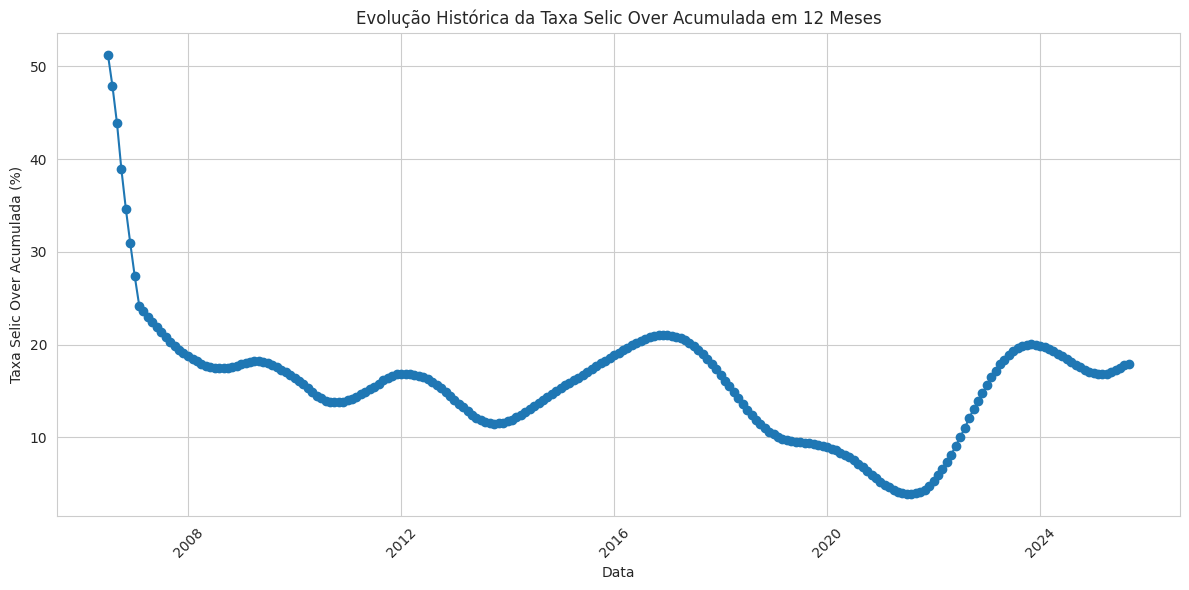

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style("whitegrid")

# Create the plot for the 12-month accumulated Selic Over
plt.figure(figsize=(12, 6))
# Use the independent calculated accumulated series
plt.plot(df_selic_over_accumulated_12m_monthly_independent.index, df_selic_over_accumulated_12m_monthly_independent.values, marker='o', linestyle='-')

# Add titles and labels
plt.title('Evolução Histórica da Taxa Selic Over Acumulada em 12 Meses')
plt.xlabel('Data')
plt.ylabel('Taxa Selic Over Acumulada (%)')

# Improve date formatting on the x-axis
plt.xticks(rotation=45)
plt.tight_layout() # Adjust layout to prevent labels overlapping

# Display the plot
plt.show()

## Salvando JSON

In [61]:
import json

# Prepare the accumulated Selic Over data for JSON
# Use the df_selic_over_accumulated_12m_monthly_independent Series
# The index is the Date, and the values are the accumulated Selic Over rates.

# Create a list of dictionaries, one for each data point
data_list_accumulated = []
for index, value in df_selic_over_accumulated_12m_monthly_independent.items():
    # Exclude NaN values which appear at the beginning of the rolling calculation
    if pd.notna(value):
        data_list_accumulated.append({
            "date": index.strftime('%Y-%m-%d'), # Format date as YYYY-MM-DD
            "rate": value # Use the accumulated Selic Over rate value
        })

# Create the final dictionary structure for the accumulated Selic Over
json_output_accumulated = {
    "indicatorName": "Taxa SELIC Over Acumulada 12 Meses (%)", # Descriptive name for the indicator
    "data": data_list_accumulated
}

# Define the output file path
output_file_path_accumulated = 'selic-over-acum-12m.json'

# Save the dictionary to a JSON file with indentation for readability
with open(output_file_path_accumulated, 'w') as f:
    json.dump(json_output_accumulated, f, indent=4)

print(f"Dados da Taxa Selic Over acumulada em 12 meses formatados e salvos em '{output_file_path_accumulated}'")

Dados da Taxa Selic Over acumulada em 12 meses formatados e salvos em 'selic-over-acum-12m.json'


In [62]:
# Display the head of the df_selic_over DataFrame
print("Primeiras 5 linhas do DataFrame df_selic_over:")
display(df_selic_over.head())

# Display the tail of the df_selic_over DataFrame
print("\nÚltimas 5 linhas do DataFrame df_selic_over:")
display(df_selic_over.tail())

# Display information about the df_selic_over DataFrame, including the date range and non-null counts
print("\nInformações do DataFrame df_selic_over:")
df_selic_over.info()

Primeiras 5 linhas do DataFrame df_selic_over:


,selic_over,selic_over_daily_decimal,selic_over_daily_growth,selic_over_accumulated_12m_daily_independent
Date,,,,
1995-01-02,0.154000,0.001540,1.001540,NaN
1995-01-03,0.153333,0.001533,1.001533,NaN
1995-01-04,0.153333,0.001533,1.001533,NaN
1995-01-05,0.153333,0.001533,1.001533,NaN
1995-01-06,0.153333,0.001533,1.001533,NaN



Últimas 5 linhas do DataFrame df_selic_over:


,selic_over,selic_over_daily_decimal,selic_over_daily_growth,selic_over_accumulated_12m_daily_independent
Date,,,,
2025-08-04,0.055131,0.000551,1.000551,17.840886
2025-08-05,0.055131,0.000551,1.000551,17.856404
2025-08-06,0.055131,0.000551,1.000551,17.871923
2025-08-07,0.055131,0.000551,1.000551,17.887445
2025-08-08,0.055131,0.000551,1.000551,17.902969



Informações do DataFrame df_selic_over:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5173 entries, 1995-01-02 to 2025-08-08
Data columns (total 4 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   selic_over                                    5173 non-null   float64
 1   selic_over_daily_decimal                      5173 non-null   float64
 2   selic_over_daily_growth                       5173 non-null   float64
 3   selic_over_accumulated_12m_daily_independent  4809 non-null   float64
dtypes: float64(4)
memory usage: 202.1 KB


## Verificando lacunas

In [63]:
# Check for gaps in the daily Selic Over data
# We can look for jumps in the index that are larger than a few days,
# accounting for weekends and holidays. A gap of more than a week is likely a data gap.

print("Verificando lacunas no DataFrame df_selic_over:")

# Get the dates from the index
dates = df_selic_over.index

# Calculate the difference between consecutive dates in days
date_diffs = (dates[1:] - dates[:-1]).days

# Find where the difference is significantly larger than expected for consecutive business days
# A normal gap is 1 day (weekday to weekday), 3 days (Friday to Monday), or 4 days (Thursday to Monday with a holiday)
# Let's consider a gap larger than 7 days as a potential data gap
potential_gaps_indices = date_diffs > 7

# Get the dates where potential gaps start and end
gap_start_dates = dates[:-1][potential_gaps_indices]
gap_end_dates = dates[1:][potential_gaps_indices]

if len(gap_start_dates) > 0:
    print("\nLacunas identificadas no DataFrame df_selic_over:")
    for start, end in zip(gap_start_dates, gap_end_dates):
        print(f"  Início da lacuna: {start.strftime('%Y-%m-%d')}, Fim da lacuna (início dos dados seguintes): {end.strftime('%Y-%m-%d')}")
else:
    print("\nNenhuma lacuna significativa (maior que 7 dias) encontrada no DataFrame df_selic_over.")

# Also, explicitly state the first and last date in the dataframe
print(f"\nPrimeira data no DataFrame df_selic_over: {df_selic_over.index.min().strftime('%Y-%m-%d')}")
print(f"Última data no DataFrame df_selic_over: {df_selic_over.index.max().strftime('%Y-%m-%d')}")

Verificando lacunas no DataFrame df_selic_over:

Lacunas identificadas no DataFrame df_selic_over:
  Início da lacuna: 1995-08-16, Fim da lacuna (início dos dados seguintes): 2005-08-15

Primeira data no DataFrame df_selic_over: 1995-01-02
Última data no DataFrame df_selic_over: 2025-08-08
